### Necessary Libraries

In [1]:
import os
import pandas as pd
import numpy as np

### Logic for fetching csv files and dumping them into specified lists

In [2]:
# path where all the required csv files are present(you can add your own path while testing)
path = "/Users/venkatasai/Desktop/ds_coursework/ParkingFineData"

# Please rename the files of both issued and fine into formats that end in "201920.csv" or into the years you want into the same format.
# So that all these files can be fetched from the path mentioned above into seperate lists
files_list = [file for file in os.listdir(path) if file.endswith("201920.csv") or file.endswith("202122.csv")]

# We have two lists from which we can obtain the issued and paid files for the selected quarters separately, 
# and we will use these lists in the subsequent process of combining the data into single dataframes. 
issued_csv_list = [file_name for file_name in files_list if len(pd.read_csv(file_name, encoding= 'unicode_escape').\
                  loc[:, ~pd.read_csv(file_name, encoding= 'unicode_escape').columns.str.contains('^Unnamed')].columns) == 5]

paid_csv_list = [file_name for file_name in files_list if len(pd.read_csv(file_name, encoding= 'unicode_escape').\
                  loc[:, ~pd.read_csv(file_name, encoding= 'unicode_escape').columns.str.contains('^Unnamed')].columns) > 5]


### Issued fines list after renaming few files

In [3]:
issued_csv_list

['Q2 201920.csv',
 'Q2 202122.csv',
 'Q3 201920.csv',
 'Q4 202122.csv',
 'Q1 202122.csv',
 'Q1 201920.csv',
 'Q3 202122.csv',
 'Q4 201920.csv']

### Paid fines list after renaming few files

In [4]:
paid_csv_list

['Quarter 2 201920.csv',
 'Quarter 2 202122.csv',
 'Quarter 3 201920.csv',
 'Quarter 4 202122.csv',
 'Quarter 1 202122.csv',
 'Quarter 1 201920.csv',
 'Quarter 3 202122.csv',
 'Quarter 4 201920.csv']

#### Function for testing the actual_filename and extracted_filename based on date for finding any mismatched records
+ <b> Step1 </b> : Concat all the dataframes
+ <b> Step2 </b> : Extract the filename into desired format based on date(extracted_filename) and compare it with the (actual_filename)
+ <b> Step3 </b> : Create a compare_result column which stores the comparision result 
+ <b> Step4 </b> : If the compare_result have results True then extracted_filename == actual_filename which gives an conclusion that only the desired quarter records are populated in the actual quarter files
+ <b> Step5 </b> : If the compare_result have results False then extracted_filename != actual_filename which gives an conclusion that only the desired quarter records are not populated in the actual quarter files(this is how we had found few wrong records populated in certain files and we had renamed the files)
+ <b> Step6 </b> : By using the above all steps the error free data is populated into the desired dataframes

+ <b> <font color='red'>Note</font> </b> : Same Function can be used across all the quarters with slight modifications and filter the undesired results and rename the files as per the domain results derivative context

In [5]:
def check_concatenated_data(target_list, date_colname):
    
    """
    arg1: target_list - pass issued_csv_list or paid_csv_list
    arg2: date_colname - pass 'ISSUED' when it's issued_csv_list and pass 'Last Pay Date' when it's paid_csv_list
    
    """

    dfs = []
    for file in target_list:
        
        file_df = pd.read_csv(file, encoding= 'unicode_escape')
        file_df[date_colname] = pd.to_datetime(file_df[date_colname], dayfirst=True)
        file_df['financial_year'] = file_df[date_colname].dt.to_period('Q-MAR').astype(str)
        file_df['org_year_quarter'] = file_df[date_colname].map(lambda x: x.year if x.month > 3 else x.year-1).astype(str) + \
        file_df['financial_year'].str[4:]
        
        if date_colname == 'ISSUED':
            file_df['extracted_filename'] = file_df['org_year_quarter'].str[4:] + ' ' + file_df['org_year_quarter'].str[0:4] + \
            (file_df['org_year_quarter'].str[2:4].astype(int)  + 1).astype(str) + '.csv'
            
        else:
            file_df['extracted_filename'] = file_df['org_year_quarter'].str[4:] + ' ' + file_df['org_year_quarter'].str[0:4] + \
            (file_df['org_year_quarter'].str[2:4].astype(int)  + 1).astype(str) + '.csv'
    
            file_df['extracted_filename'] = file_df['extracted_filename'].apply(lambda x: x.replace("Q", "Quarter "))
            
        file_df['actual_filename'] = file
        dfs.append(file_df)

    combined_df = pd.concat(dfs, ignore_index=True).\
                        loc[:, ~pd.concat(dfs, ignore_index=True).columns.str.contains('^Unnamed')]

    combined_df['compare_result'] = np.where((combined_df['actual_filename'] == \
                                           combined_df['extracted_filename'])
                                            ,True, False)
    
    combined_df.drop(['financial_year', 'org_year_quarter'], axis=1, inplace=True)

    
    return combined_df

### <b> <font color='green'>Observations from the issued_fines data</font> </b>

In [6]:
issued_fine_data = check_concatenated_data(issued_csv_list, 'ISSUED')
issued_fine_data.head()

,PCN,ISSUED,LOCATION,CONTRAVENTION,FINE,extracted_filename,actual_filename,compare_result
0,LS02467046,2019-07-01,BECKETT ST LOWER CP - CITY,82 AFTER EXPIRY IN P+D CAR PARK,50,Q2 201920.csv,Q2 201920.csv,True
1,LS02467057,2019-07-01,HUNSLET LANE CP - CITY,83 WITHOUT DISPLAYING A VALID TICKET,50,Q2 201920.csv,Q2 201920.csv,True
2,LS05156122,2019-07-01,WOODHOUSE LANE CP - CITY,83 WITHOUT DISPLAYING A VALID TICKET,50,Q2 201920.csv,Q2 201920.csv,True
3,LS0665751A,2019-07-01,CASTLE ST CP - CITY,73 PARKED WITHOUT PAYMENT,50,Q2 201920.csv,Q2 201920.csv,True
4,LS06657520,2019-07-01,CASTLE ST CP - CITY,73 PARKED WITHOUT PAYMENT,50,Q2 201920.csv,Q2 201920.csv,True


In [7]:
print(f"The total number of records present in issued_fines: {issued_fine_data.shape[0]}")
print(f"The count of PCN numbers across all the selected quarters for issued_fines: {len(issued_fine_data['PCN'].tolist())}")
print(f"The count of distinct PCN numbers across all the selected quarters for issued_fines: {len(issued_fine_data['PCN'].unique().tolist())}")


The total number of records present in issued_fines: 18141
The count of PCN numbers across all the selected quarters for issued_fines: 18141
The count of distinct PCN numbers across all the selected quarters for issued_fines: 18141


+ There are no repeated PCN numbers in the issued_fine_data which gives a conclusion that each row in the selected data corresponds to an unique fine. As seen in the above result, total number of PCN is equal to distinct number of PCN.

### <b> <font color='green'>Observations from the paid_fines data</font> </b>

In [8]:
paid_fine_data = check_concatenated_data(paid_csv_list, 'Last Pay Date')
paid_fine_data.head()

,PCN,ISSUED,LOCATION,CONTRAVENTION,FINE,Last Pay Date,Total Paid,Balance,extracted_filename,actual_filename,compare_result
0,LS01119328,28/02/2017,QUARRY HILL C CP - CITY,83 WITHOUT DISPLAYING A VALID TICKET,50,2019-08-01,83.0,0.0,Quarter 2 201920.csv,Quarter 2 201920.csv,True
1,LS07212417,18/07/2017,QUARRY HILL C CP - CITY,83 WITHOUT DISPLAYING A VALID TICKET,50,2019-08-01,83.0,0.0,Quarter 2 201920.csv,Quarter 2 201920.csv,True
2,LS0591308A,22/08/2017,QUARRY HILL B CP - CITY,83 WITHOUT DISPLAYING A VALID TICKET,50,2019-08-01,83.0,0.0,Quarter 2 201920.csv,Quarter 2 201920.csv,True
3,LS06620440,06/09/2017,HUNSLET LANE CP - CITY,83 WITHOUT DISPLAYING A VALID TICKET,50,2019-09-18,0.0,83.0,Quarter 2 201920.csv,Quarter 2 201920.csv,True
4,LS0721988A,22/12/2017,BECKETT ST UPPER CP - CITY,73 PARKED WITHOUT PAYMENT,50,2019-09-10,0.0,0.0,Quarter 2 201920.csv,Quarter 2 201920.csv,True


+ It is evident that the PCN numbers are repeated in the paid_fines_data but that makes sense because one PCN number fine can be paid across multiple quarters

In [9]:
print(f"The total number of records present in paid_fines: {paid_fine_data.shape[0]}")
print(f"The count of distinct PCN numbers across all the selected quarters for paid_fines : {len(paid_fine_data['PCN'].tolist())}")
print(f"The count of distinct PCN numbers across all the selected quarters for paid_fines : {len(paid_fine_data['PCN'].unique().tolist())}")

The total number of records present in paid_fines: 43971
The count of distinct PCN numbers across all the selected quarters for paid_fines : 43971
The count of distinct PCN numbers across all the selected quarters for paid_fines : 21481


#### Number of Fines issued per quarter and Number of Fines paid per quarter

In [31]:
issued_data_count = issued_fine_data.groupby(['actual_filename']).size().reset_index(name='number_of_records')
issued_data_count['actual_filename'] = issued_data_count['actual_filename'].apply(lambda x: x.replace(".csv", ""))
issued_data_count['type'] = 'Issued'
paid_data_count = paid_fine_data.groupby(['actual_filename']).size().reset_index(name='number_of_records')
paid_data_count['actual_filename'] = paid_data_count['actual_filename'].apply(lambda x: x.replace("Quarter ", "Q"))
paid_data_count['actual_filename'] = paid_data_count['actual_filename'].apply(lambda x: x.replace(".csv", ""))
paid_data_count['type'] = 'Paid'
merged_issued_paid_count_df = issued_data_count.merge(paid_data_count, left_index=True, right_index=True, how='inner')
merged_issued_paid_count_df.rename(columns = {'actual_filename_x' : 'Issued_filename', 'number_of_records_x' : 'Fines_issued_count',
                                              'actual_filename_y' : 'Paid_filename', 'number_of_records_y' : 'Fines_paid_count'}, inplace=True)
merged_issued_paid_count_df = merged_issued_paid_count_df[['Issued_filename', 'Fines_issued_count', 'Paid_filename', 'Fines_paid_count']]
combined_df = pd.concat([issued_data_count, paid_data_count],ignore_index=True)


In [33]:
merged_issued_paid_count_df

,Issued_filename,Fines_issued_count,Paid_filename,Fines_paid_count
0,Q1 201920,2776,Q1 201920,6498
1,Q1 202122,1547,Q1 202122,3452
2,Q2 201920,2931,Q2 201920,6859
3,Q2 202122,1867,Q2 202122,4074
4,Q3 201920,3178,Q3 201920,7196
5,Q3 202122,1455,Q3 202122,3540
6,Q4 201920,2926,Q4 201920,9145
7,Q4 202122,1461,Q4 202122,3207


In [34]:
combined_df.to_csv('final_data.csv', index=False)

In [38]:
combined_df

,actual_filename,number_of_records,type
0,Q1 201920,2776,Issued
1,Q1 202122,1547,Issued
2,Q2 201920,2931,Issued
3,Q2 202122,1867,Issued
4,Q3 201920,3178,Issued
5,Q3 202122,1455,Issued
6,Q4 201920,2926,Issued
7,Q4 202122,1461,Issued
8,Q1 201920,6498,Paid
9,Q1 202122,3452,Paid


### Issued vs Paid fines trend

+ <b> <font color='red'>Future Work</font> </b> : Results are subject to change after removing false records in the paid_fine_data 

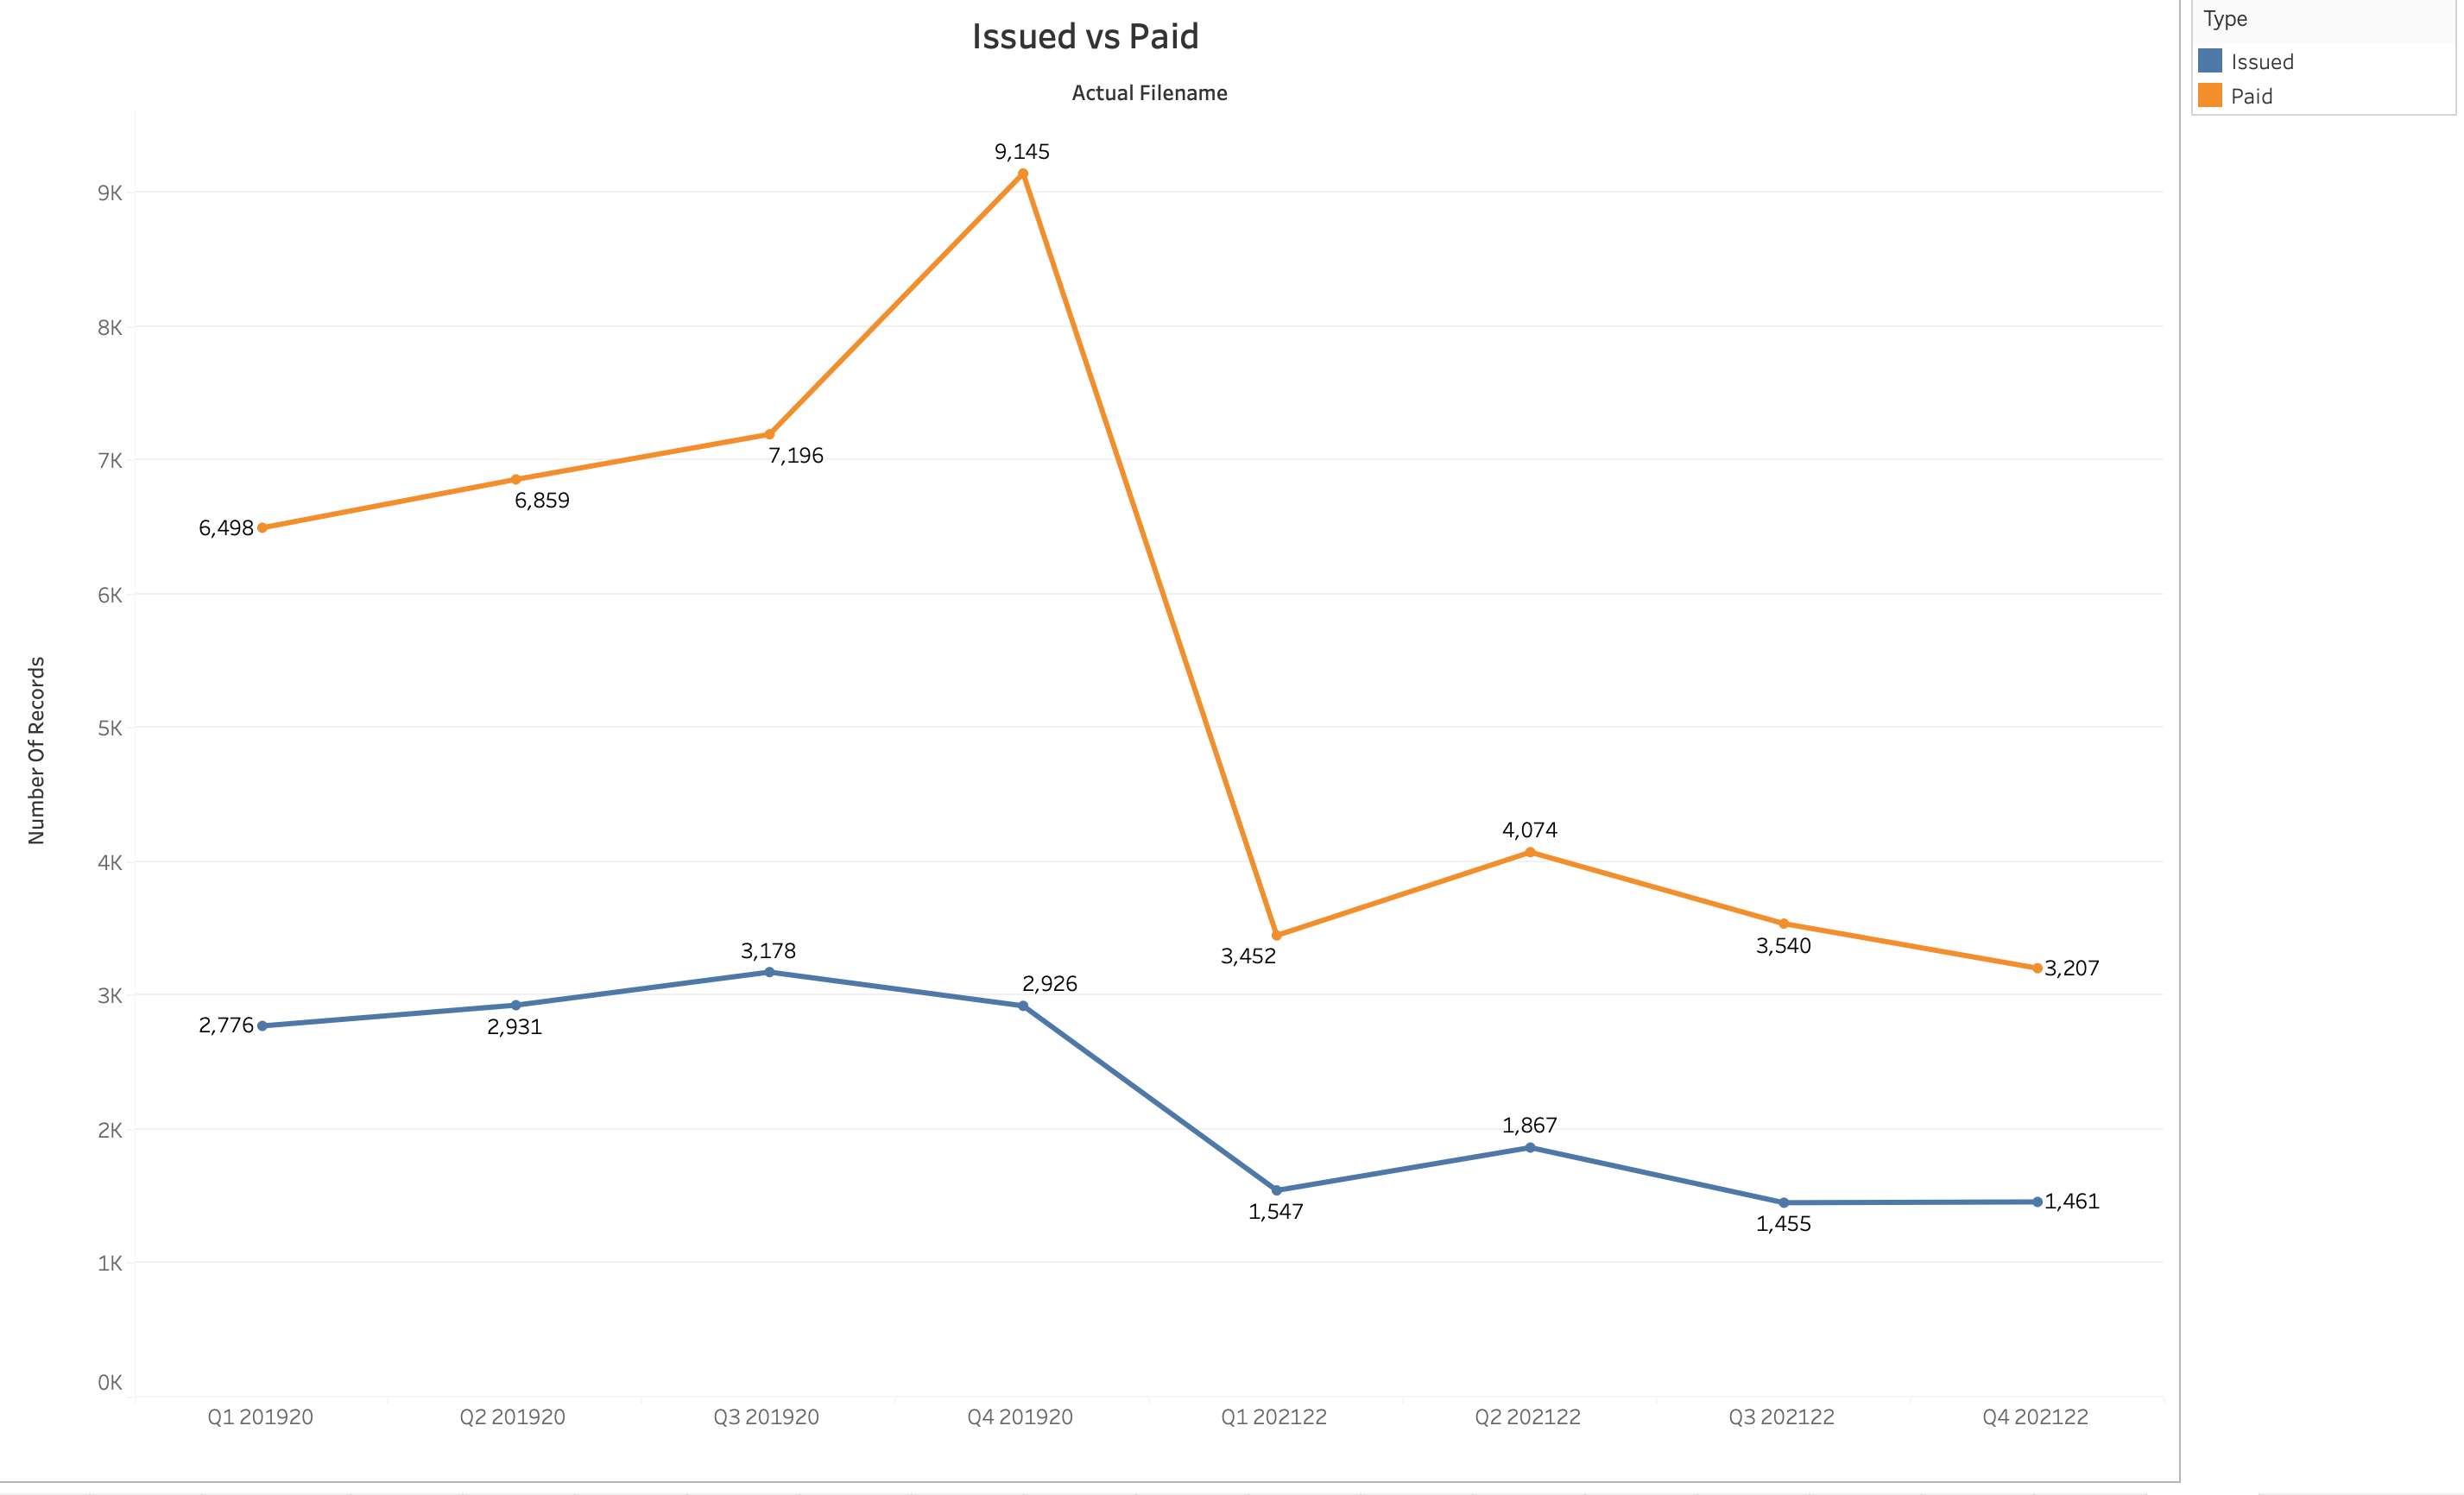

In [37]:
from IPython.display import Image
Image(filename='results.png') 